In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit
from tqdm import tqdm

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, computeMSD

# Update source files before running each cell
%load_ext autoreload
%autoreload 2

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [2]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-02-01.h5'

# We will want to look at longer trajectories here since we want to examine
# timescales longer than 15 seconds.
minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = 15 # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Removing trajectories near walls: 100%|███████| 479/479 [01:11<00:00,  6.71it/s]

Loaded 838 segments!


In [3]:
maxTime = 20 # [s]
bins = 30

dt = 1/metadataArr[0]["fps"]

# We store things based on the original trial they come
# from, so we can get the average (or median) value for each trial,
# plus the overall average. See comments above this cell.
trialMembership = np.array([m["dataset"] for m in metadataArr])
uniqueTrials = np.unique(trialMembership)
indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))
# trialIndicesArr[i] gives the indices of all of the segments that belong to trial i
trialIndicesArr = [np.where(trialMembership == trial)[0] for trial in uniqueTrials]

msdArr = np.zeros((len(uniqueTrials), bins))

for j in tqdm(range(len(uniqueTrials))): 
    segmentList = [dataArr[k] for k in trialIndicesArr[j]]
    timeList = [timeArr[k] for k in trialIndicesArr[j]]
    
    lagArr, msdArr[j] = computeMSD(segmentList, t=timeList,
                                   minLag=2*dt, maxLag=maxTime, nbins=bins, logbins=True)

100%|███████████████████████████████████████████| 81/81 [00:02<00:00, 38.72it/s]


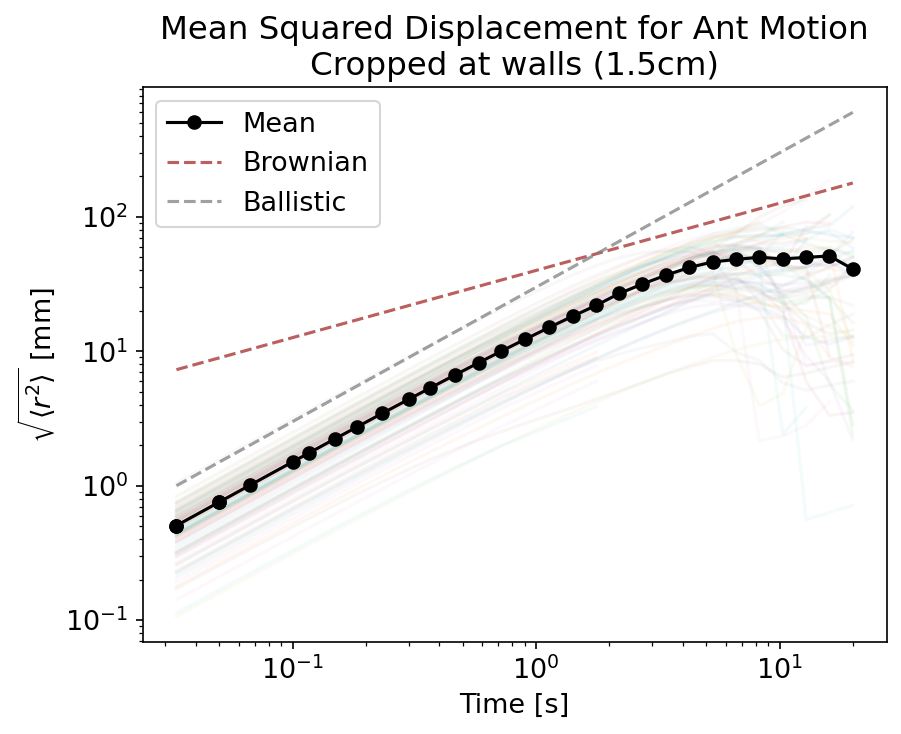

In [4]:
order = np.arange(len(uniqueTrials))
np.random.shuffle(order)
 
for i in order:
    plt.plot(lagArr, np.sqrt(msdArr[i]), '-', alpha=0.05)

mean = np.nanmean(msdArr, axis=0)

plt.plot(lagArr, np.sqrt(mean), '-o', c='black', label='Mean')

plt.plot(lagArr, 40*(lagArr)**(1/2), '--', c='brown', label='Brownian', alpha=0.75)
plt.plot(lagArr, 30*(lagArr)**1, '--', c='gray', label='Ballistic', alpha=0.75)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('$\\sqrt{\\langle r^2 \\rangle}$ [mm]')
#plt.title(f'Mean Squared Displacement for Ant Motion\nUncropped')
plt.title(f'Mean Squared Displacement for Ant Motion\nCropped at walls (1.5cm)')
#plt.title(f'Mean Squared Displacement for Ant Motion\nOnly at walls (2 cm)')
plt.legend()
#pltsaveall('06_MSD_OnlyWalls')
plt.show()

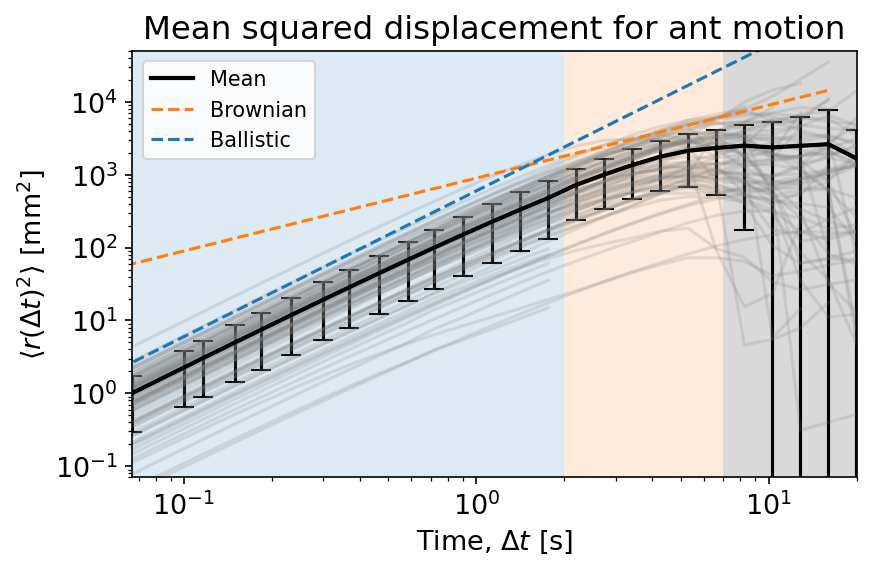

In [9]:
order = np.arange(len(uniqueTrials))
np.random.shuffle(order)
fps = metadataArr[0]["fps"]

# Fill in regimes
ymax = 5e4
ymin = 7e-2

rect = mpl.patches.Rectangle((np.min(lagArr), ymin), 
                             2e0 - np.min(lagArr), ymax - ymin,
                             color='tab:blue', 
                             alpha=0.15,
                             linewidth=0, zorder=-20)

rect2 = mpl.patches.Rectangle((2e0, ymin), 
                              7e0 - 2e0, ymax - ymin,
                              color='tab:orange', 
                              alpha=0.15,
                              linewidth=0, zorder=-10)

rect3 = mpl.patches.Rectangle((7e0, ymin), 
                              np.max(lagArr) - 7e0, ymax - ymin,
                              color='black', 
                              alpha=0.15,
                              linewidth=0, zorder=-10)

plt.gca().add_patch(rect)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)

mean = np.nanmean(msdArr, axis=0)
std = np.nanstd(msdArr, axis=0)

plt.errorbar(lagArr, mean, yerr=std, color='black', alpha=1, capsize=5)

for i in order:
    plt.plot(lagArr, msdArr[i], '-', alpha=0.2, c='gray')


plt.plot(lagArr, mean, c='black', label='Mean', linewidth=2)

plt.plot(lagArr[:-1], 900*(lagArr[:-1])**1, '--', c='tab:orange', label='Brownian', alpha=1)
plt.plot(lagArr[:-1], 600*(lagArr[:-1])**2, '--', c='tab:blue', label='Ballistic', alpha=1)

#plt.axhline(170)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time, $\\Delta t$ [s]')
plt.ylabel('$\\langle r(\\Delta t)^2 \\rangle$ [mm$^2$]')
plt.ylim([ymin, ymax])
plt.xlim([4*dt, 2e1])
#plt.title(f'Mean Squared Displacement for Ant Motion\nUncropped')
plt.title(f'Mean squared displacement for ant motion')
#plt.title(f'Mean Squared Displacement for Ant Motion\nOnly at walls (2 cm)')
plt.legend(fontsize=10)
plt.gcf().set_size_inches((6,4))
plt.gcf().tight_layout()
pltsaveall('06_MSD_Regimes')
plt.show()

## Fit ballistic regime

In [50]:
# I tried fitting with both fixing beta=2 and letting it vary, but it doesn't
# make much difference. If you let it vary, it will end up give a median
# value of around 1.85, which is close enough to 2 given the uncertainty.
#def fitFunction(t, A, beta):
#    return A * t**beta

def fitFunction(t, A):
    return A * t**2

# You might get slightly better or worse results by changing these parameters
# a little bit; tMax should be about the same or less than tau, the average run
# length.
tMax = 1. # seconds
velocityThreshold = 5 # mm/s

vArr = np.zeros(len(uniqueTrials))
betaArr = np.zeros(len(uniqueTrials))

trialMembership = np.array([m["dataset"] for m in metadataArr])
uniqueTrials = np.unique(trialMembership)
# trialIndicesArr[i] gives the indices of all of the segments that belong to trial i
trialIndicesArr = [np.where(trialMembership == trial)[0] for trial in uniqueTrials]

for i in tqdm(range(len(uniqueTrials))):
    x = lagArr[lagArr <= tMax]
    y = msdArr[i][lagArr <= tMax]

    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    
    pOpt, pCov = curve_fit(fitFunction, x, y, p0=(1))#, 2))

    vArr[i] = np.sqrt(pOpt[0])
#    betaArr[i] = pOpt[1]

# Compute velocity manually
directVArr = np.zeros(len(uniqueTrials))

# First for loops over discretization parameters
# Second for loops over trials
for j in tqdm(range(len(uniqueTrials))):
    speed = []
    # Third for loops over segments in trials
    for k in trialIndicesArr[j]:        
        velocity = (dataArr[k][1:] - dataArr[k][:-1]) * fps
        speed += list(np.sqrt(np.sum(velocity**2, axis=-1)))

    # Remove low speeds; this is the part where the calculation depends
    # on the discretization parameters, though only very mildly.
    speed = np.array(speed)
    directVArr[j] = np.nanmedian(speed[speed > velocityThreshold])


100%|██████████████████████████████████████████| 83/83 [00:00<00:00, 946.44it/s]


Median direct fit velocity: 16.273956298828125 mm/s
Median discrete fit persistence time: 12.489773891990533 seconds


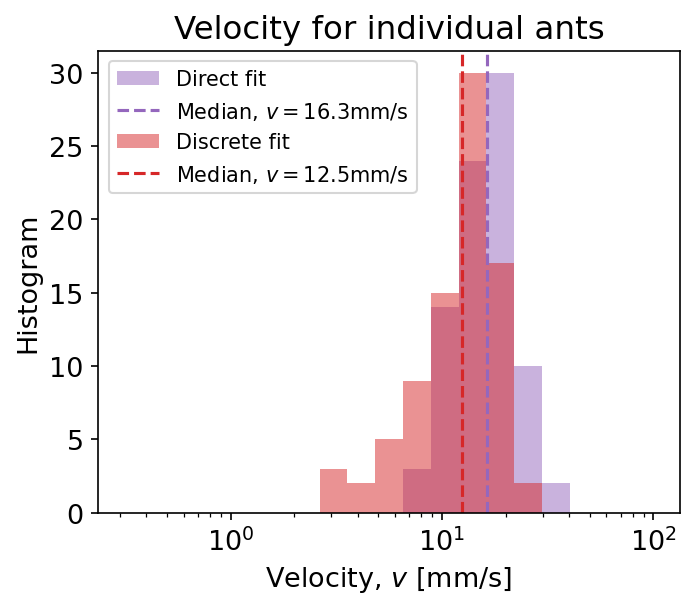

In [51]:
plt.hist(directVArr, bins=np.logspace(-0.5, 2, 20), density=False, alpha=0.5, color='tab:purple', label='Direct fit')
plt.axvline(np.nanmedian(directVArr), linestyle='--', color='tab:purple', label=f'Median, $v = {np.nanmedian(directVArr):.3}$mm/s')

print(f'Median direct fit velocity: {np.nanmedian(directVArr)} mm/s')

plt.hist(vArr, bins=np.logspace(-0.5, 2, 20), density=False, alpha=0.5, color='tab:red', label='Discrete fit')

plt.axvline(np.nanmedian(vArr), linestyle='--', color='tab:red', label=f'Median, $v = {np.nanmedian(vArr):.3}$mm/s')

print(f'Median discrete fit persistence time: {np.nanmedian(vArr)} seconds')

plt.xscale('log')
#plt.ylim([0.8e-2, 1.2e0])
#plt.yticks([0, 5, 10, 15, 20])
plt.legend(fontsize=10)
plt.xlabel('Velocity, $v$ [mm/s]')
plt.ylabel('Histogram')
plt.title('Velocity for individual ants')
plt.gcf().set_size_inches((5,4))
#plt.savefig('velocity_comparison.pdf', bbox_inches='tight')
plt.show()

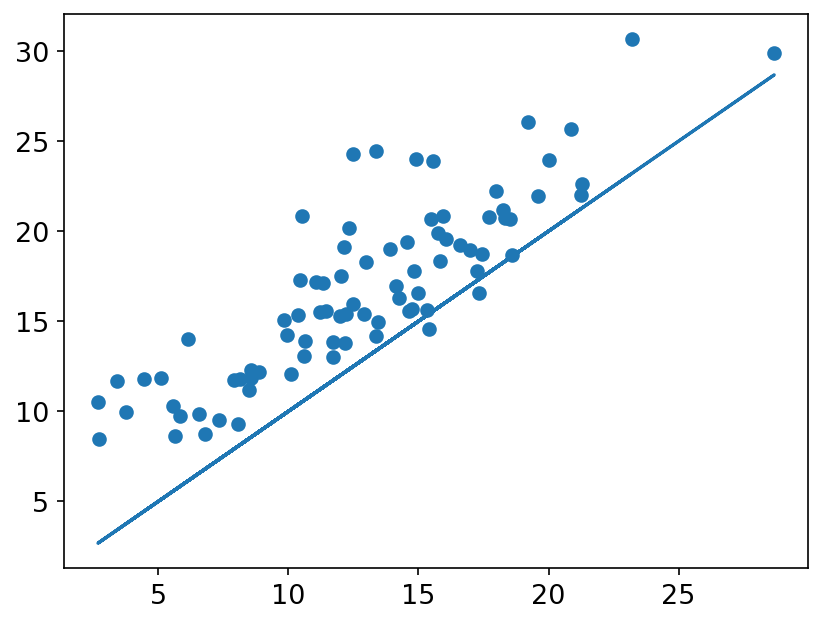

In [52]:
plt.scatter(vArr, directVArr)
plt.plot(vArr, vArr)
plt.show()